# Task 2 (Experimentation and Uplifting Testing) Solution

In [1]:
# Importing important libraries
import pandas as pd
import numpy as np
import missingno

# Visualization Libraries
import matplotlib.pyplot as plt 

# Statistics Libraries
from statistics import stdev
from scipy.stats import t

# Dates
import matplotlib.dates as mdates

## Table: QVI_data

In [2]:
# df will be a shortcut for the dataframe of the QVI_data table
# reading the table from csv file into pandas dataframe

df = pd.read_csv('QVI_data.csv')

df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
df.shape

(264834, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
df.dtypes

LYLTY_CARD_NBR        int64
DATE                 object
STORE_NBR             int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
PACK_SIZE             int64
BRAND                object
LIFESTAGE            object
PREMIUM_CUSTOMER     object
dtype: object

The date column has string data type and needs to be fixed. Let us convert it to date type and proceed after that with the rest of requirements.

In [6]:
df['DATE'] = df['DATE'].astype('datetime64[ns]')
df.dtypes

LYLTY_CARD_NBR               int64
DATE                datetime64[ns]
STORE_NBR                    int64
TXN_ID                       int64
PROD_NBR                     int64
PROD_NAME                   object
PROD_QTY                     int64
TOT_SALES                  float64
PACK_SIZE                    int64
BRAND                       object
LIFESTAGE                   object
PREMIUM_CUSTOMER            object
dtype: object

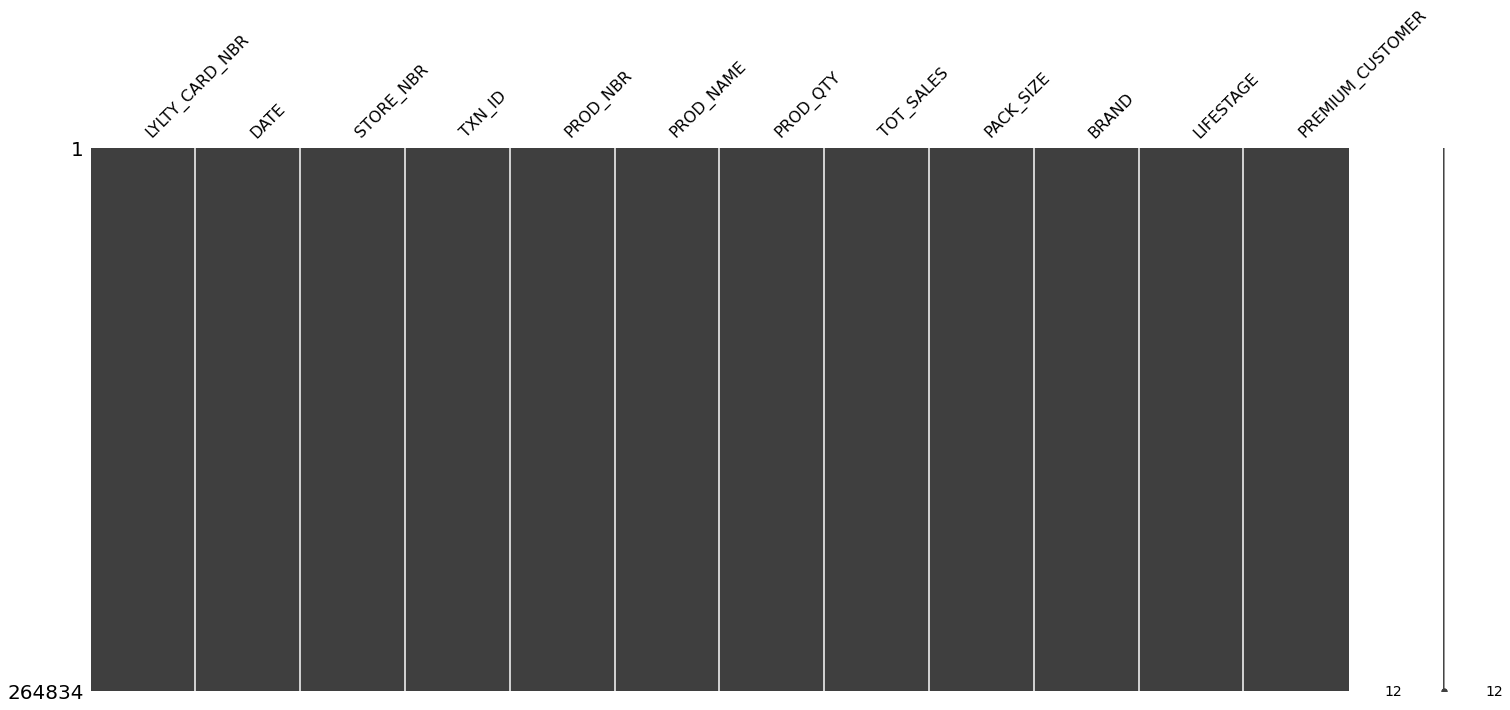

In [7]:
# checking missing values

missingno.matrix(df);

In [8]:
df.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [9]:
df.count()

LYLTY_CARD_NBR      264834
DATE                264834
STORE_NBR           264834
TXN_ID              264834
PROD_NBR            264834
PROD_NAME           264834
PROD_QTY            264834
TOT_SALES           264834
PACK_SIZE           264834
BRAND               264834
LIFESTAGE           264834
PREMIUM_CUSTOMER    264834
dtype: int64

In [10]:
df.nunique()

LYLTY_CARD_NBR       72636
DATE                   364
STORE_NBR              272
TXN_ID              263125
PROD_NBR               114
PROD_NAME              114
PROD_QTY                 5
TOT_SALES              111
PACK_SIZE               21
BRAND                   21
LIFESTAGE                7
PREMIUM_CUSTOMER         3
dtype: int64

So the basic exploration has been done until here and also the data type of the date column has been fixed. Let us proceed with the core of the task. The first task which has to be achieved is selecting the control stores. We need to keep in mind that the client already selected stores 77, 86 and 88 as trial stores and we need the control stores to be similar to the trail stores prior to the trial period of Feb 2019 to compare them.

The main metrics we will consider here are:
* Monthly overall sales revenue
* Monthly number of customers
* Monthly number of transactions per customer

### 1- Selecting the Control Stores

We can start with the following two important procedures:\
1- Create the metrics.\
2- Filter out stores that are present throughout the pre-trial period.

In [11]:
# The first we need to do here is to create YEARMONTH feature

# This first is a long one way
# df['year'] = df['DATE'].dt.year.astype(str)
# df['month'] = df['DATE'].dt.month.map("{:02}".format).astype(str)
# df['YEARMONTH'] = df['year'] + df['month']

df['YEARMONTH'] = df['DATE'].dt.year.astype(str)+df['DATE'].dt.month.map("{:02}".format).astype(str)
df['YEARMONTH'] = pd.to_numeric(df['YEARMONTH'])
df['YEARMONTH']

0         201810
1         201809
2         201903
3         201903
4         201811
           ...  
264829    201812
264830    201810
264831    201810
264832    201810
264833    201812
Name: YEARMONTH, Length: 264834, dtype: int64

Now we will compute Total sales, Number of customers, Transaction per customer,Chips per transaction, and Average price per unit for each store and month by using group by. We will create individual dataframe and then concatenate all of them together at the end.

In [12]:
# Sum of the total store monthly sales

Sales = df.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum()
Sales

STORE_NBR  YEARMONTH
1          201807       206.9
           201808       176.1
           201809       278.8
           201810       188.1
           201811       192.6
                        ...  
272        201902       395.5
           201903       442.3
           201904       445.1
           201905       314.6
           201906       312.1
Name: TOT_SALES, Length: 3169, dtype: float64

In [13]:
# Count of number of customers using specific store in each month

Customers = df.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()
Customers

STORE_NBR  YEARMONTH
1          201807       49
           201808       42
           201809       59
           201810       44
           201811       46
                        ..
272        201902       45
           201903       50
           201904       54
           201905       34
           201906       34
Name: LYLTY_CARD_NBR, Length: 3169, dtype: int64

In [14]:
# Transactions per customer for each store in each month

TPC = df.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique() / df.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()
TPC

STORE_NBR  YEARMONTH
1          201807       1.061224
           201808       1.023810
           201809       1.050847
           201810       1.022727
           201811       1.021739
                          ...   
272        201902       1.066667
           201903       1.060000
           201904       1.018519
           201905       1.176471
           201906       1.088235
Length: 3169, dtype: float64

In [15]:
# Total number of chips per transaction for each store and month

CPT = df.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum() / df.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique()
CPT

STORE_NBR  YEARMONTH
1          201807       1.192308
           201808       1.255814
           201809       1.209677
           201810       1.288889
           201811       1.212766
                          ...   
272        201902       1.895833
           201903       1.905660
           201904       1.909091
           201905       1.775000
           201906       1.891892
Length: 3169, dtype: float64

In [16]:
# Monthly store average price per unit

PPU = df.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum() / df.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum()
PPU

STORE_NBR  YEARMONTH
1          201807       3.337097
           201808       3.261111
           201809       3.717333
           201810       3.243103
           201811       3.378947
                          ...   
272        201902       4.346154
           201903       4.379208
           201904       4.239048
           201905       4.430986
           201906       4.458571
Length: 3169, dtype: float64

In [17]:
# Concatenating the above generated dataframes.

conc_dfs = [Sales, Customers, TPC, CPT, PPU]
conc_dfs

[STORE_NBR  YEARMONTH
 1          201807       206.9
            201808       176.1
            201809       278.8
            201810       188.1
            201811       192.6
                         ...  
 272        201902       395.5
            201903       442.3
            201904       445.1
            201905       314.6
            201906       312.1
 Name: TOT_SALES, Length: 3169, dtype: float64,
 STORE_NBR  YEARMONTH
 1          201807       49
            201808       42
            201809       59
            201810       44
            201811       46
                         ..
 272        201902       45
            201903       50
            201904       54
            201905       34
            201906       34
 Name: LYLTY_CARD_NBR, Length: 3169, dtype: int64,
 STORE_NBR  YEARMONTH
 1          201807       1.061224
            201808       1.023810
            201809       1.050847
            201810       1.022727
            201811       1.021739
                

In [18]:
type(conc_dfs)

list

In [19]:
# They have the same length and so we can concatenate them.

over_time_measure = pd.concat(conc_dfs, join = 'outer', axis = 1)
over_time_measure

TOT_SALES  LYLTY_CARD_NBR         0         1         2
STORE_NBR YEARMONTH                                                         
1         201807         206.9              49  1.061224  1.192308  3.337097
          201808         176.1              42  1.023810  1.255814  3.261111
          201809         278.8              59  1.050847  1.209677  3.717333
          201810         188.1              44  1.022727  1.288889  3.243103
          201811         192.6              46  1.021739  1.212766  3.378947
...                        ...             ...       ...       ...       ...
272       201902         395.5              45  1.066667  1.895833  4.346154
          201903         442.3              50  1.060000  1.905660  4.379208
          201904         445.1              54  1.018519  1.909091  4.239048
          201905         314.6              34  1.176471  1.775000  4.430986
          201906         312.1              34  1.088235  1.891892  4.458571

[3169 rows x 5 columns]

In [20]:
type(over_time_measure)

pandas.core.frame.DataFrame

In [21]:
over_time_measure.rename(columns = {'TOT_SALES': 'totSales', 'LYLTY_CARD_NBR': 'nCustomers', 0: 'nChipsPerCust', 1: 'nChipsPerTxn', 2: 'avgPricePerUnit'}, inplace = True)
over_time_measure.head()

totSales  nCustomers  nChipsPerCust  nChipsPerTxn  \
STORE_NBR YEARMONTH                                                      
1         201807        206.9          49       1.061224      1.192308   
          201808        176.1          42       1.023810      1.255814   
          201809        278.8          59       1.050847      1.209677   
          201810        188.1          44       1.022727      1.288889   
          201811        192.6          46       1.021739      1.212766   

                     avgPricePerUnit  
STORE_NBR YEARMONTH                   
1         201807            3.337097  
          201808            3.261111  
          201809            3.717333  
          201810            3.243103  
          201811            3.378947

In [22]:
# Which stores do not have full observation i.e. have months where there is no transaction for chips

check_nulls = pd.pivot_table(df, index = 'STORE_NBR', columns = 'YEARMONTH', values = 'TXN_ID', aggfunc = 'count')
check_nulls

YEARMONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,52.0,43.0,62.0,45.0,47.0,47.0,36.0,55.0,49.0,43.0,51.0,43.0
2,41.0,43.0,37.0,43.0,40.0,38.0,45.0,32.0,46.0,49.0,50.0,42.0
3,138.0,134.0,119.0,119.0,118.0,129.0,121.0,139.0,130.0,110.0,123.0,122.0
4,160.0,151.0,138.0,155.0,139.0,133.0,168.0,102.0,135.0,137.0,126.0,134.0
5,120.0,112.0,125.0,107.0,111.0,125.0,118.0,106.0,97.0,109.0,104.0,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...
268,52.0,54.0,34.0,48.0,51.0,43.0,38.0,37.0,47.0,50.0,52.0,40.0
269,139.0,132.0,124.0,148.0,136.0,133.0,144.0,133.0,122.0,139.0,130.0,127.0
270,139.0,154.0,126.0,119.0,133.0,149.0,155.0,125.0,143.0,132.0,128.0,127.0


In [23]:
check_nulls.isnull().sum()

YEARMONTH
201807    6
201808    9
201809    8
201810    7
201811    8
201812    9
201901    9
201902    8
201903    7
201904    7
201905    9
201906    8
dtype: int64

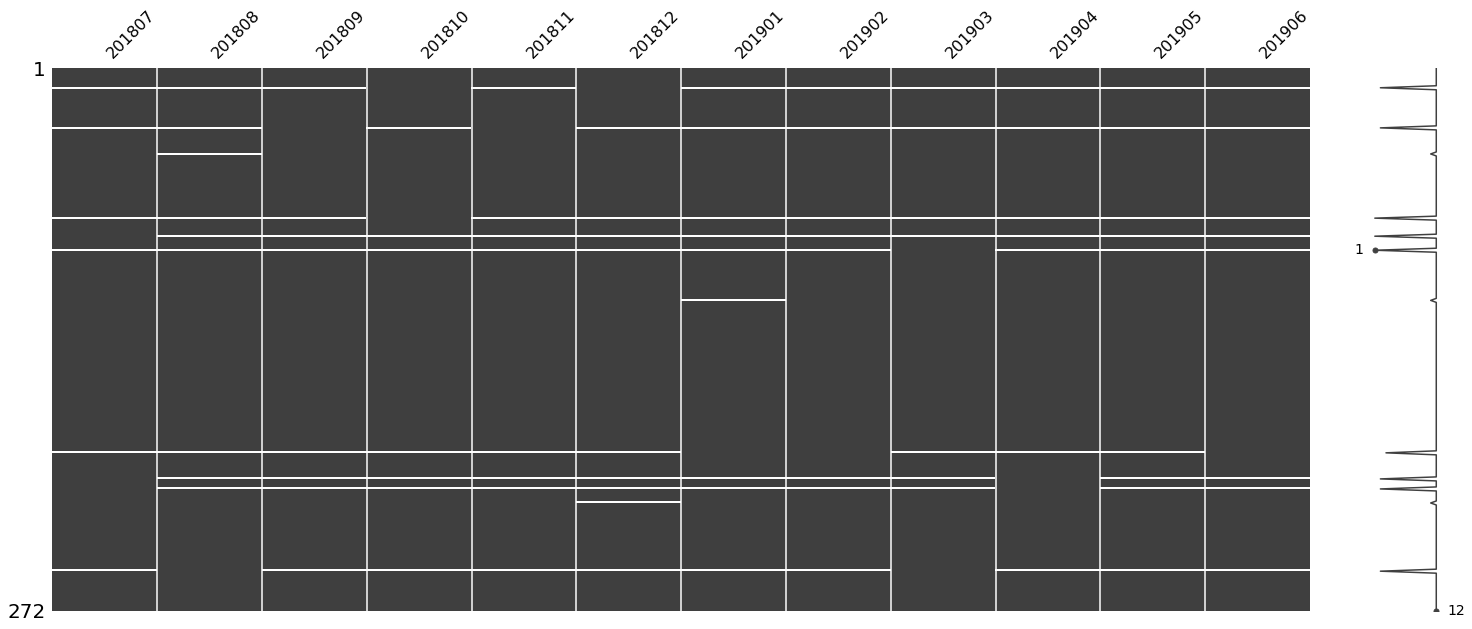

In [24]:
missingno.matrix(check_nulls);

In [25]:
check_nulls.isnull()

YEARMONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
268,False,False,False,False,False,False,False,False,False,False,False,False
269,False,False,False,False,False,False,False,False,False,False,False,False
270,False,False,False,False,False,False,False,False,False,False,False,False


In [26]:
check_nulls.isnull().any()

YEARMONTH
201807    True
201808    True
201809    True
201810    True
201811    True
201812    True
201901    True
201902    True
201903    True
201904    True
201905    True
201906    True
dtype: bool

In [27]:
check_nulls.isnull().any(axis=1)

STORE_NBR
1      False
2      False
3      False
4      False
5      False
       ...  
268    False
269    False
270    False
271    False
272    False
Length: 272, dtype: bool

In [28]:
check_nulls[check_nulls.isnull().any(axis=1)]

YEARMONTH,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906
STORE_NBR,,,,,,,,,,,,
11,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,4.0,NaN,3.0,5.0,4.0,7.0,5.0,4.0,6.0,5.0,6.0,9.0
76,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
117,1.0,4.0,4.0,7.0,7.0,8.0,NaN,2.0,2.0,5.0,4.0,2.0
193,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0
206,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [29]:
check_nulls[check_nulls.isnull().any(axis=1)].index

Int64Index([11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252], dtype='int64', name='STORE_NBR')

In [30]:
null_store = check_nulls[check_nulls.isnull().any(axis=1)].index.tolist()
null_store

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [31]:
len(null_store)

12

We need to delete these rows from the over_time_measure dataframe. Let us check its index.

In [32]:
over_time_measure.index

MultiIndex([(  1, 201807),
            (  1, 201808),
            (  1, 201809),
            (  1, 201810),
            (  1, 201811),
            (  1, 201812),
            (  1, 201901),
            (  1, 201902),
            (  1, 201903),
            (  1, 201904),
            ...
            (272, 201809),
            (272, 201810),
            (272, 201811),
            (272, 201812),
            (272, 201901),
            (272, 201902),
            (272, 201903),
            (272, 201904),
            (272, 201905),
            (272, 201906)],
           names=['STORE_NBR', 'YEARMONTH'], length=3169)

Let us reset its index.

In [33]:
over_time_measure.reset_index(inplace=True)
over_time_measure.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947


In [34]:
over_time_measure['STORE_NBR'].isin(null_store)

0       False
1       False
2       False
3       False
4       False
        ...  
3164    False
3165    False
3166    False
3167    False
3168    False
Name: STORE_NBR, Length: 3169, dtype: bool

In [35]:
~over_time_measure['STORE_NBR'].isin(null_store)

0       True
1       True
2       True
3       True
4       True
        ... 
3164    True
3165    True
3166    True
3167    True
3168    True
Name: STORE_NBR, Length: 3169, dtype: bool

In [36]:
over_time_measure = over_time_measure[~over_time_measure['STORE_NBR'].isin(null_store)]
over_time_measure

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,1.895833,4.346154
3165,272,201903,442.3,50,1.060000,1.905660,4.379208
3166,272,201904,445.1,54,1.018519,1.909091,4.239048
3167,272,201905,314.6,34,1.176471,1.775000,4.430986


In [37]:
# Create new dataframe 'preTrialMeasures' 
# Filter to pre-trial period i.e. before 201902

preTrialMeasures = over_time_measure.loc[over_time_measure['YEARMONTH'] < 201902, :]
preTrialMeasures

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549
3160,272,201810,430.6,44,1.136364,1.980000,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


Let us create a function which calculates the correlation between trial store and other stores based on a metric.

In [38]:
def calculateCorrelation(inputTable, metric, trial_store):
    """
    This function calculates the correlation between trial store and other stores based on a metric.
    """
    
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Correlation': []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output = output.append({'Store1': trial_store, 'Store2': i, 'Correlation': b.corr(a)}, ignore_index = True)
    return output

Let us create another function which calculates a standardised magnitude difference.

In [39]:
def calculateMagnitudeDistance(inputTable, metric, trial_store):
    """
    This function calculates a standardised magnitude difference.
    """
    
    output = pd.DataFrame({'Store1': [], 'Store2': [], 'Magnitude' : []})
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        output = output.append({'Store1': trial_store, 'Store2': i, 'Magnitude': d}, ignore_index = True)
    return output

### Choosing the Control Store for the Trail Store Number 77

We will use the two functions above to find the control store.

In [40]:
trial_store = 77
corr_nSales = calculateCorrelation(preTrialMeasures, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialMeasures, 'nCustomers', trial_store)

magnitude_nSales = calculateMagnitudeDistance(preTrialMeasures, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialMeasures, 'nCustomers', trial_store)

In [41]:
corr_nSales.head()

,Store1,Store2,Correlation
0,77.0,1.0,0.075218
1,77.0,2.0,-0.263079
2,77.0,3.0,0.806644
3,77.0,4.0,-0.263300
4,77.0,5.0,-0.110652


In [42]:
magnitude_nSales.head()

,Store1,Store2,Magnitude
0,77.0,1.0,0.408163
1,77.0,2.0,0.590119
2,77.0,3.0,0.522914
3,77.0,4.0,0.644934
4,77.0,5.0,0.516320


We will concatenate the above two dataframes.

In [43]:
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)
score_nSales.head()

,Store1,Store2,Correlation,Magnitude
0,77.0,1.0,0.075218,0.408163
1,77.0,2.0,-0.263079,0.590119
2,77.0,3.0,0.806644,0.522914
3,77.0,4.0,-0.263300,0.644934
4,77.0,5.0,-0.110652,0.516320


We need to add average weight.

In [44]:
corr_weight = 0.5
score_nSales['scoreNSales'] = corr_weight * score_nSales['Correlation'] + (1 - corr_weight) * score_nSales['Magnitude']
score_nSales.head()

,Store1,Store2,Correlation,Magnitude,scoreNSales
0,77.0,1.0,0.075218,0.408163,0.241691
1,77.0,2.0,-0.263079,0.590119,0.163520
2,77.0,3.0,0.806644,0.522914,0.664779
3,77.0,4.0,-0.263300,0.644934,0.190817
4,77.0,5.0,-0.110652,0.516320,0.202834


We will repeat the same steps above for 'nCustomers'.

In [45]:
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)
score_nCustomers['scoreNCust'] = corr_weight * score_nCustomers['Correlation'] + (1 - corr_weight) * score_nCustomers['Magnitude']
score_nCustomers.head()

,Store1,Store2,Correlation,Magnitude,scoreNCust
0,77.0,1.0,0.322168,0.663866,0.493017
1,77.0,2.0,-0.572051,0.471429,-0.050311
2,77.0,3.0,0.834207,0.489796,0.662002
3,77.0,4.0,-0.295639,0.498258,0.101310
4,77.0,5.0,0.370659,0.512605,0.441632


Let us reset the index and concatenate the two dataframes above.

In [46]:
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)

score_Control = pd.concat([score_nSales['scoreNSales'], score_nCustomers['scoreNCust']], axis = 1)
score_Control

scoreNSales  scoreNCust
Store1 Store2                         
77.0   1.0        0.241691    0.493017
       2.0        0.163520   -0.050311
       3.0        0.664779    0.662002
       4.0        0.190817    0.101310
       5.0        0.202834    0.441632
...                    ...         ...
       268.0      0.387272    0.470473
       269.0      0.121684    0.005090
       270.0      0.453489    0.202710
       271.0      0.348289    0.174100
       272.0      0.320626    0.384336

[260 rows x 2 columns]

Now we will compute the average of 'scoreNSales' and 'scoreNCust' and add it as a new column.

In [47]:
score_Control['finalControlScore'] = 0.5 * (score_Control['scoreNSales'] + score_Control['scoreNCust'])
score_Control.head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
77.0   1.0        0.241691    0.493017           0.367354
       2.0        0.163520   -0.050311           0.056604
       3.0        0.664779    0.662002           0.663390
       4.0        0.190817    0.101310           0.146064
       5.0        0.202834    0.441632           0.322233

Let's check the top 5 stores with highest 'finalControlScore'.

In [48]:
score_Control.sort_values(by = 'finalControlScore', ascending = False).head()

scoreNSales  scoreNCust  finalControlScore
Store1 Store2                                            
77.0   233.0      0.697290    0.816607           0.756949
       71.0       0.789497    0.663123           0.726310
       84.0       0.656972    0.715000           0.685986
       119.0      0.636046    0.729729           0.682887
       115.0      0.708347    0.645155           0.676751

We can see that store 233 match store 77 better than other according the finalControlScore. let's check visually if the drivers are indeed similar to store 77 before the trial period

In [49]:
control_store = 233

pastSales = preTrialMeasures

# Create a new column within 'pastSales' which categorises store type
store_type = []

for i in pastSales['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i == control_store:
        store_type.append('Control Store')
    else:
        store_type.append('Other Stores')

pastSales['store_type'] = store_type
pastSales['store_type'].unique()

C:\Users\Zia\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


array(['Other Stores', 'Trial Store', 'Control Store'], dtype=object)

In [50]:
pastSales.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores


In [51]:
pastSales.dtypes

STORE_NBR            int64
YEARMONTH            int64
totSales           float64
nCustomers           int64
nChipsPerCust      float64
nChipsPerTxn       float64
avgPricePerUnit    float64
store_type          object
dtype: object

We can see that the YEARMONTH has an integer data type and needs to be converted to date. We will do that by adding a new column.

In [52]:
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format = '%Y%m')
pastSales.head()

C:\Users\Zia\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,store_type,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,Other Stores,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,Other Stores,2018-11-01


We need to create 'totSales' visualisation for control store, trial store and other stores. Let us create relevant dataframes for each one.

In [53]:
controlSalesPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'totSales']]
controlSalesPlot

,TransactionMonth,totSales
2699,2018-07-01,290.7
2700,2018-08-01,285.9
2701,2018-09-01,228.6
2702,2018-10-01,185.7
2703,2018-11-01,211.6
2704,2018-12-01,279.8
2705,2019-01-01,177.5


In [54]:
controlSalesPlot.set_index('TransactionMonth', inplace = True)
controlSalesPlot

,totSales
TransactionMonth,
2018-07-01,290.7
2018-08-01,285.9
2018-09-01,228.6
2018-10-01,185.7
2018-11-01,211.6
2018-12-01,279.8
2019-01-01,177.5


In [55]:
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)
controlSalesPlot

,Control Store
TransactionMonth,
2018-07-01,290.7
2018-08-01,285.9
2018-09-01,228.6
2018-10-01,185.7
2018-11-01,211.6
2018-12-01,279.8
2019-01-01,177.5


In [56]:
# The same has been done for Trail and Others.
trialSalesPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'totSales']]
trialSalesPlot.set_index('TransactionMonth', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)
otherSalesPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('TransactionMonth').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

In [57]:
trialSalesPlot

,Trial Store
TransactionMonth,
2018-07-01,296.8
2018-08-01,255.5
2018-09-01,225.2
2018-10-01,204.5
2018-11-01,245.3
2018-12-01,267.3
2019-01-01,204.4


In [58]:
otherSalesPlot

,Other Stores
TransactionMonth,
2018-07-01,638.004651
2018-08-01,610.223450
2018-09-01,620.198450
2018-10-01,635.314729
2018-11-01,618.864341
2018-12-01,648.453876
2019-01-01,628.684496


Let us combine the above created dataframes and then visualize.

In [59]:
combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,290.7,296.8,638.004651
2018-08-01,285.9,255.5,610.223450
2018-09-01,228.6,225.2,620.198450
2018-10-01,185.7,204.5,635.314729
2018-11-01,211.6,245.3,618.864341
2018-12-01,279.8,267.3,648.453876
2019-01-01,177.5,204.4,628.684496


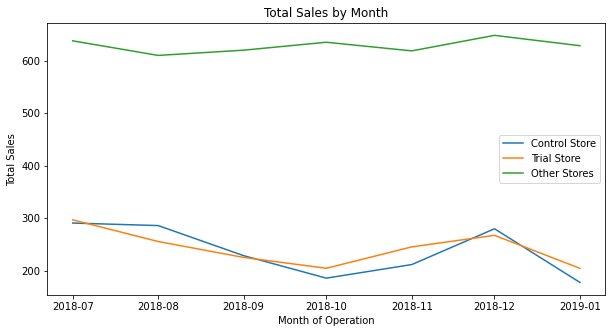

In [60]:
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

The same steps can be repeated for 'nCustomers'.

In [61]:
# First create relevant dataframes 
controlCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Control Store', ['TransactionMonth', 'nCustomers']]
controlCustomersPlot.set_index('TransactionMonth', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)
trialCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Trial Store', ['TransactionMonth', 'nCustomers']]
trialCustomersPlot.set_index('TransactionMonth', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)
otherCustomersPlot = pastSales.loc[pastSales['store_type'] == 'Other Stores', ['TransactionMonth', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('TransactionMonth').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([controlCustomersPlot, trialCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Control Store,Trial Store,Other Stores
TransactionMonth,,,
2018-07-01,51,51,72.333333
2018-08-01,48,47,72.120155
2018-09-01,42,42,70.131783
2018-10-01,35,37,71.608527
2018-11-01,40,41,70.534884
2018-12-01,47,46,73.515504
2019-01-01,35,35,71.240310


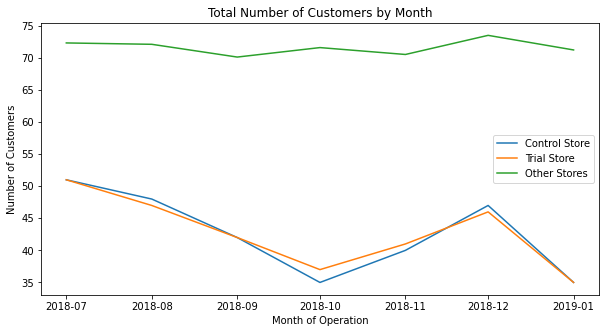

In [62]:
plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

### Trail Assessment of the Trail Store Number 77

Let us investigate if was an uplift in the chips sales in the trail period (start of February 2019 to end of April 2019).

We will need to figure out a scaling factor to apply to the control store. We will calculate it by dividing sum of 'totSales' for trial store by sum of 'totSales' for control store.


In [63]:
trial_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

1.023617303289553

Now let us just pick up the control store which was 233 from the measureOverTime dataframe.

In [64]:
scaledControlSales = over_time_measure.loc[over_time_measure['STORE_NBR'] == control_store]
scaledControlSales

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit
2699,233,201807,290.7,51,1.058824,1.629630,3.303409
2700,233,201808,285.9,48,1.041667,1.600000,3.573750
2701,233,201809,228.6,42,1.071429,1.555556,3.265714
2702,233,201810,185.7,35,1.028571,1.555556,3.316071
2703,233,201811,211.6,40,1.025000,1.512195,3.412903
2704,233,201812,279.8,47,1.063830,1.500000,3.730667
2705,233,201901,177.5,35,1.000000,1.342857,3.776596
2706,233,201902,244.0,45,1.044444,1.489362,3.485714
2707,233,201903,199.1,40,1.025000,1.439024,3.374576
2708,233,201904,158.6,30,1.066667,1.437500,3.447826


Let us now apply 'scalingFactorSales' to 'totSales' column.

In [65]:
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

C:\Users\Zia\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,297.565550
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,292.652187
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,233.998916
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,190.085733
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,216.597421


In [66]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEARMONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'totSales'
trialSales = over_time_measure.loc[over_time_measure['STORE_NBR'] == trial_store, 'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

percentageDiff

,YEARMONTH,controlSales,trialSales
0,201807,297.565550,296.8
1,201808,292.652187,255.5
2,201809,233.998916,225.2
3,201810,190.085733,204.5
4,201811,216.597421,245.3
5,201812,286.408121,267.3
6,201901,181.692071,204.4
7,201902,249.762622,235.0
8,201903,203.802205,278.5
9,201904,162.345704,263.5


Let us find percentage difference and add it as a new column to the dataframe above.

In [67]:
percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEARMONTH,controlSales,trialSales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


The null hypothesis is such that the trial period is the same as the pre-trial period. Let's also take the standard deviation based on the scaled percentage difference in the pre-trial period.

In [68]:
stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.049940762641425544

Since we have 8 pre-trial months, the degree of freedom = 8 - 1 = 7. We will test with a null hypothesis of there being 0 difference between trial and control stores.


In [69]:
dof = 7

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     1.183534
8     7.339116
9    12.476373
Name: tValue, dtype: float64

Let us find the 95th percentile of the t distribution with dof = 7.

In [70]:
t.isf(0.05, dof)

1.8945786050613054

We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April.

Let us visualize now. We need to add a month column first. Then we create a new dataframe and Extract 'controlSales' from 'scaledControlSales' dataframe for control store. 

In [71]:
scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEARMONTH'].astype(str), format = '%Y%m')
scaledControlSales

C:\Users\Zia\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,controlSales,TransactionMonth
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,297.565550,2018-07-01
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,292.652187,2018-08-01
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,233.998916,2018-09-01
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,190.085733,2018-10-01
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,216.597421,2018-11-01
2704,233,201812,279.8,47,1.063830,1.500000,3.730667,286.408121,2018-12-01
2705,233,201901,177.5,35,1.000000,1.342857,3.776596,181.692071,2019-01-01
2706,233,201902,244.0,45,1.044444,1.489362,3.485714,249.762622,2019-02-01
2707,233,201903,199.1,40,1.025000,1.439024,3.374576,203.802205,2019-03-01
2708,233,201904,158.6,30,1.066667,1.437500,3.447826,162.345704,2019-04-01


In [72]:
controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales

,Control Sales
TransactionMonth,
2018-07-01,297.565550
2018-08-01,292.652187
2018-09-01,233.998916
2018-10-01,190.085733
2018-11-01,216.597421
2018-12-01,286.408121
2019-01-01,181.692071
2019-02-01,249.762622
2019-03-01,203.802205


Let us also create a new column 'TransationMonth' under 'over_time_measure' dataframe and then Extract 'totSales' for trial store from 'over_time_measure'.

In [73]:
over_time_measure['TransactionMonth'] = pd.to_datetime(over_time_measure['YEARMONTH'].astype(str), format = '%Y%m')
over_time_measure.head()

C:\Users\Zia\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
0,1,201807,206.9,49,1.061224,1.192308,3.337097,2018-07-01
1,1,201808,176.1,42,1.023810,1.255814,3.261111,2018-08-01
2,1,201809,278.8,59,1.050847,1.209677,3.717333,2018-09-01
3,1,201810,188.1,44,1.022727,1.288889,3.243103,2018-10-01
4,1,201811,192.6,46,1.021739,1.212766,3.378947,2018-11-01


In [74]:
trialSales = over_time_measure.loc[over_time_measure['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,296.8
2018-08-01,255.5
2018-09-01,225.2
2018-10-01,204.5
2018-11-01,245.3
2018-12-01,267.3
2019-01-01,204.4
2019-02-01,235.0
2019-03-01,278.5


Let us also create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval. After that we Merge the two dataframes together 'controlSales' and 'trialSales'.

In [75]:
controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,297.565550,267.844249,327.286851
2018-08-01,292.652187,263.421640,321.882734
2018-09-01,233.998916,210.626747,257.371084
2018-10-01,190.085733,171.099680,209.071786
2018-11-01,216.597421,194.963341,238.231502
2018-12-01,286.408121,257.801241,315.015001
2019-01-01,181.692071,163.544390,199.839753
2019-02-01,249.762622,224.815950,274.709294
2019-03-01,203.802205,183.446130,224.158280


In [76]:
combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,297.565550,267.844249,327.286851,296.8
2018-08-01,292.652187,263.421640,321.882734,255.5
2018-09-01,233.998916,210.626747,257.371084,225.2
2018-10-01,190.085733,171.099680,209.071786,204.5
2018-11-01,216.597421,194.963341,238.231502,245.3
2018-12-01,286.408121,257.801241,315.015001,267.3
2019-01-01,181.692071,163.544390,199.839753,204.4
2019-02-01,249.762622,224.815950,274.709294,235.0
2019-03-01,203.802205,183.446130,224.158280,278.5


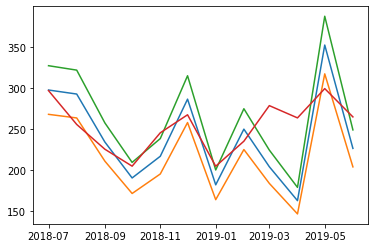

In [77]:
plt.plot(combineSales);

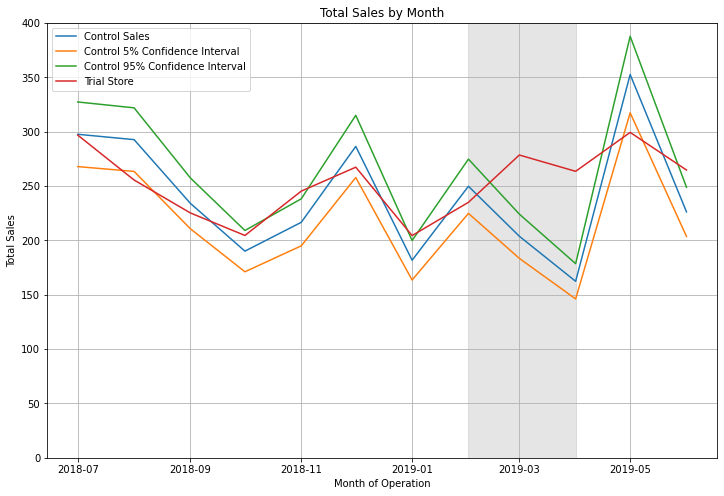

In [78]:
# Make it bigger
plt.figure(figsize = (12, 8))
plt.plot(combineSales)

# Set graph title and axis title
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')

# Set legend
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

# Set new y-axis limit
plt.ylim((0, 400))

# Highlight trial period
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

# Set grid
plt.grid()
plt.show()

The results above show that the trial in store 77 is significantly different to its control store in the trial period. The trial store performance lies outside the 5% and 95% confidence intervals in the two of the 3 trial months.

We will repeat almost the same procedures for nCustomers.

In [79]:
trial_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialMeasures.loc[preTrialMeasures['store_type'] == 'Control Store', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

1.0033557046979866

In [80]:
scaledControlCustomers = over_time_measure.loc[over_time_measure['STORE_NBR'] == control_store]
scaledControlCustomers.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,2018-07-01
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,2018-08-01
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,2018-09-01
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,2018-10-01
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,2018-11-01


In [81]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

C:\Users\Zia\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,STORE_NBR,YEARMONTH,totSales,nCustomers,nChipsPerCust,nChipsPerTxn,avgPricePerUnit,TransactionMonth,controlCustomers
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,2018-07-01,51.171141
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,2018-08-01,48.161074
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,2018-09-01,42.140940
2702,233,201810,185.7,35,1.028571,1.555556,3.316071,2018-10-01,35.117450
2703,233,201811,211.6,40,1.025000,1.512195,3.412903,2018-11-01,40.134228


In [82]:
percentageDiff = scaledControlCustomers[['YEARMONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

trialCustomers = over_time_measure.loc[over_time_measure['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEARMONTH,controlCustomers,trialCustomers
0,201807,51.171141,51
1,201808,48.161074,47
2,201809,42.140940,42
3,201810,35.117450,37
4,201811,40.134228,41
5,201812,47.157718,46
6,201901,35.117450,35
7,201902,45.151007,45
8,201903,40.134228,50
9,201904,30.100671,47


In [83]:
percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEARMONTH,controlCustomers,trialCustomers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344
3,201810,35.117450,37,0.053607
4,201811,40.134228,41,0.021572
5,201812,47.157718,46,0.024550
6,201901,35.117450,35,0.003344
7,201902,45.151007,45,0.003344
8,201903,40.134228,50,0.245819
9,201904,30.100671,47,0.561427


In [84]:
stdDev = stdev(percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'])
stdDev

0.018240748558243945

In [85]:
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905), 'tValue']

7     0.183352
8    13.476388
9    30.778725
Name: tValue, dtype: float64

In [86]:
t.isf(0.05, dof)

1.8945786050613054

We can see that the t-value is much larger than the 95th percentile value of the t-distribution for March and April.

In [87]:
controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,51.171141
2018-08-01,48.161074
2018-09-01,42.140940
2018-10-01,35.117450
2018-11-01,40.134228
2018-12-01,47.157718
2019-01-01,35.117450
2019-02-01,45.151007
2019-03-01,40.134228


In [88]:
trialCustomers = over_time_measure.loc[over_time_measure['STORE_NBR'] == trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,51
2018-08-01,47
2018-09-01,42
2018-10-01,37
2018-11-01,41
2018-12-01,46
2019-01-01,35
2019-02-01,45
2019-03-01,50


In [89]:
controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,51.171141,49.304341,53.037941
2018-08-01,48.161074,46.404086,49.918062
2018-09-01,42.140940,40.603575,43.678304
2018-10-01,35.117450,33.836313,36.398587
2018-11-01,40.134228,38.670071,41.598385
2018-12-01,47.157718,45.437334,48.878102
2019-01-01,35.117450,33.836313,36.398587
2019-02-01,45.151007,43.503830,46.798183
2019-03-01,40.134228,38.670071,41.598385


In [90]:
combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,51.171141,49.304341,53.037941,51
2018-08-01,48.161074,46.404086,49.918062,47
2018-09-01,42.140940,40.603575,43.678304,42
2018-10-01,35.117450,33.836313,36.398587,37
2018-11-01,40.134228,38.670071,41.598385,41
2018-12-01,47.157718,45.437334,48.878102,46
2019-01-01,35.117450,33.836313,36.398587,35
2019-02-01,45.151007,43.503830,46.798183,45
2019-03-01,40.134228,38.670071,41.598385,50


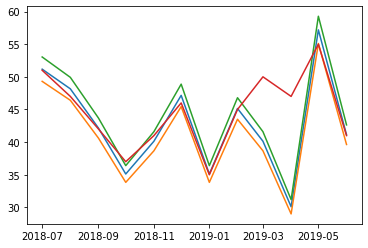

In [91]:
plt.plot(combineCustomers);

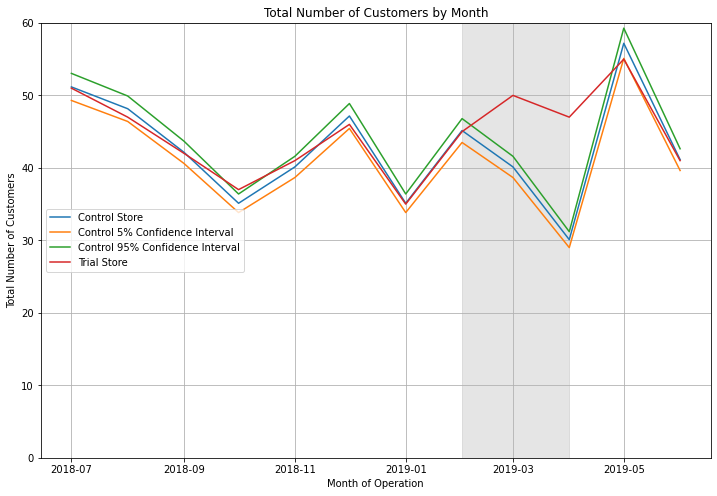

In [92]:
plt.figure(figsize = (12, 8))
plt.plot(combineCustomers)

plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')

plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 6)

plt.ylim((0, 60))

plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

plt.grid()
plt.show()

The same procedures achieved above can be repeated for finding the control store and assessing the impact of the trial for the two remaining trial stores, 86 and 88.